In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np
import math
import pickle

In [3]:
import code.form_trajectories

In [4]:

list_of_files = []
subjectID = []
activityIDdict = { }
colNames = []
IMUhand = []
IMUchest = []
IMUankle = []
columns = []

list_of_files, subjectID, activityIDdict, colNames, IMUhand, IMUchest, IMUankle, columns = code.form_trajectories.load_indices()
len(columns)

54

## Загрузка данных

Объединим информацию из всех файлов в один датасет сопаставив каждому временному ряду человека и активность

In [5]:
dataCollection = code.form_trajectories.formDataFrame(list_of_files, columns)

In [6]:
dataCollection.head(20)

,timestamp,activityID,heartrate,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,...,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4,subject_id
0,8.38,0,104.0,30.0,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,...,0.009250,-0.017580,-61.1888,-38.9599,-58.1438,1.0,0.0,0.0,0.0,1
1,8.39,0,NaN,30.0,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,...,-0.004638,0.000368,-59.8479,-38.8919,-58.5253,1.0,0.0,0.0,0.0,1
2,8.40,0,NaN,30.0,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,...,0.000148,0.022495,-60.7361,-39.4138,-58.3999,1.0,0.0,0.0,0.0,1
3,8.41,0,NaN,30.0,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,...,-0.020301,0.011275,-60.4091,-38.7635,-58.3956,1.0,0.0,0.0,0.0,1
4,8.42,0,NaN,30.0,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,...,-0.014303,-0.002823,-61.5199,-39.3879,-58.2694,1.0,0.0,0.0,0.0,1
5,8.43,0,NaN,30.0,2.29959,8.82929,3.54710,2.26132,8.65762,3.77788,...,-0.016024,0.001050,-60.2954,-38.8778,-58.3977,1.0,0.0,0.0,0.0,1
6,8.44,0,NaN,30.0,2.33738,8.82900,3.54767,2.27703,8.77828,3.73230,...,-0.053934,0.015594,-60.6307,-38.8676,-58.2711,1.0,0.0,0.0,0.0,1
7,8.45,0,NaN,30.0,2.37142,9.05500,3.39347,2.39786,8.89814,3.64131,...,-0.039937,-0.000785,-60.5171,-38.9819,-58.2733,1.0,0.0,0.0,0.0,1
8,8.46,0,NaN,30.0,2.33951,9.13251,3.54668,2.44371,8.98841,3.62596,...,-0.010042,0.017701,-61.2916,-39.6182,-58.1499,1.0,0.0,0.0,0.0,1
9,8.47,0,NaN,30.0,2.25966,9.09415,3.43015,2.42877,9.01871,3.61081,...,-0.013923,0.014498,-60.8509,-39.0821,-58.1478,1.0,0.0,0.0,0.0,1


Отбираем только данные с нужных сенсоров (в данном случае с одно акселерометра) и ключи (человек, активность)

In [10]:
#selected_sensors = ['ankleGyro1', 'ankleGyro2', 'ankleGyro3']
selected_sensors = ['ankleGyro1', 'ankleGyro2', 'ankleGyro3', 'chestGyro1', 'chestGyro2', 'chestGyro3', 'handGyro1', 'handGyro2', 'handGyro3']
selected_features = ['activityID'] + selected_sensors + ['subject_id']
activityID = [3, 4, 5, 6]
dataCol = code.form_trajectories.dataCleaning(dataCollection, selected_features, activityID, activityIDdict)
dataCol.reset_index(drop=True, inplace=True)

In [11]:
dataCol.head(20)

,activityID,ankleGyro1,ankleGyro2,ankleGyro3,chestGyro1,chestGyro2,chestGyro3,handGyro1,handGyro2,handGyro3,subject_id
0,3,0.016202,0.071309,-0.037459,-0.025781,0.001630,-0.016456,0.109104,0.012499,0.007080,1
1,3,-0.032161,-0.003190,-0.024105,-0.012441,-0.007175,-0.024283,0.005999,-0.022118,0.030519,1
2,3,0.003597,0.022367,-0.022196,-0.037032,0.032145,-0.025020,-0.022800,-0.041052,0.029532,1
3,3,-0.012857,-0.016368,0.020723,-0.018491,0.042010,-0.024520,-0.034290,-0.025008,0.012352,1
4,3,-0.070664,-0.007592,-0.032125,-0.036642,0.045820,-0.048493,-0.031431,0.027357,-0.000961,1
5,3,0.005593,0.003036,-0.001103,0.006990,0.035168,-0.044906,-0.019102,-0.002645,0.024971,1
6,3,0.007197,0.025083,0.013287,0.005441,0.032280,-0.026977,-0.014749,0.021008,0.000723,1
7,3,-0.015100,-0.002933,-0.019332,-0.033625,0.028823,-0.022945,0.027798,0.014171,-0.001448,1
8,3,0.011513,-0.051580,0.002339,0.021777,-0.013771,-0.019729,-0.010903,-0.035610,-0.022780,1
9,3,0.010709,-0.048499,-0.014965,0.011131,0.064263,-0.026792,-0.008845,0.020809,-0.040150,1


Теперь объединяем данные с одного временного ряда в траекторию

In [12]:
all_velocities, targets = code.form_trajectories.set_trajectory_target(subjectID, activityID, selected_sensors, dataCol)

       ankleGyro1  ankleGyro2  ankleGyro3  chestGyro1  chestGyro2  chestGyro3  \
0        0.016202    0.071309   -0.037459   -0.025781    0.001630   -0.016456   
1       -0.032161   -0.003190   -0.024105   -0.012441   -0.007175   -0.024283   
2        0.003597    0.022367   -0.022196   -0.037032    0.032145   -0.025020   
3       -0.012857   -0.016368    0.020723   -0.018491    0.042010   -0.024520   
4       -0.070664   -0.007592   -0.032125   -0.036642    0.045820   -0.048493   
...           ...         ...         ...         ...         ...         ...   
21712    0.060603   -0.008648    0.002083   -0.032392    0.000362   -0.032731   
21713    0.000872    0.067478    0.005791    0.014612   -0.050701    0.015774   
21714    0.001346    0.003215    0.001250   -0.002278   -0.023910   -0.009162   
21715    0.027325   -0.036714    0.001732    0.014589   -0.008999   -0.014148   
21716   -0.004201   -0.065393    0.024225    0.009470    0.012848   -0.002338   

       handGyro1  handGyro2

In [14]:
all_velocities[0].shape

(506, 9)

Тепрь превратим верменные ряды по скорости в ряды по ускорению и координатам и выгрузим все на диск для дальнейшего использования

In [15]:
experiment_name = 'experiment2'

In [18]:
code.form_trajectories.form_all_trajectories(all_velocities, experiment_name)

100%|██████████| 1372/1372 [00:06<00:00, 215.43it/s]


# Расчет лагранжианов

In [ ]:
import jax
from jax.example_libraries import stax
import code.train

In [ ]:
jax_gpu = jax.devices("gpu")

In [5]:
TRAIN_DATASET_PATH = Path("code/trajectories")
TEST_DATASET_PATH = Path("code/trajectories")
LOG_DIR = Path("code/logs")

======== experiment1_1.pickle ========
iteration=0, train_loss=15789.355469, test_loss=15789.355469
iteration=1000, train_loss=2.763449, test_loss=2.763449
iteration=2000, train_loss=1.346801, test_loss=1.346801
iteration=3000, train_loss=1.200503, test_loss=1.200503
iteration=4000, train_loss=1.197698, test_loss=1.197698
iteration=5000, train_loss=1.197600, test_loss=1.197600
iteration=6000, train_loss=1.197589, test_loss=1.197589
iteration=7000, train_loss=1.197591, test_loss=1.197591
iteration=8000, train_loss=1.197591, test_loss=1.197591
iteration=9000, train_loss=1.197595, test_loss=1.197595
iteration=10000, train_loss=1.197597, test_loss=1.197597
======== experiment1_2.pickle ========
iteration=0, train_loss=15777.753906, test_loss=15777.753906
iteration=1000, train_loss=2.739643, test_loss=2.739643
iteration=2000, train_loss=1.346578, test_loss=1.346578
iteration=3000, train_loss=1.208839, test_loss=1.208839
iteration=4000, train_loss=1.206364, test_loss=1.206364
iteration=5000,

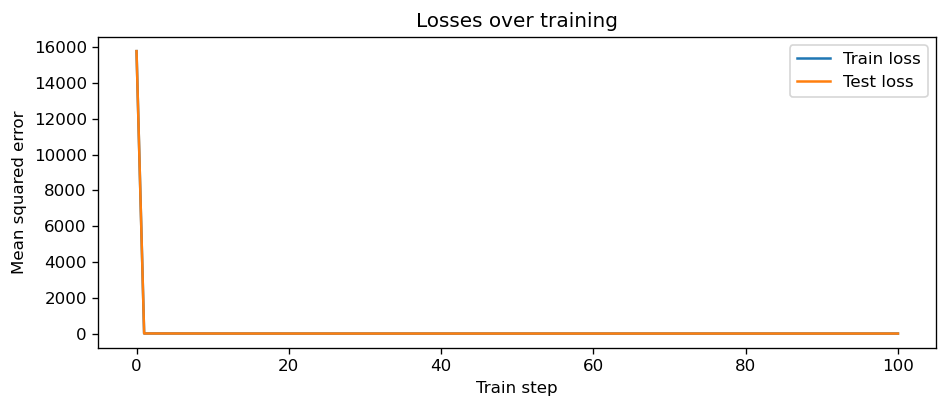

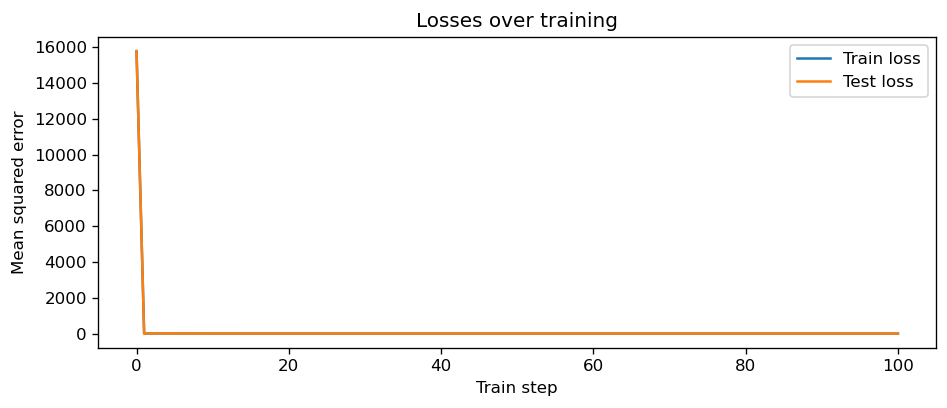

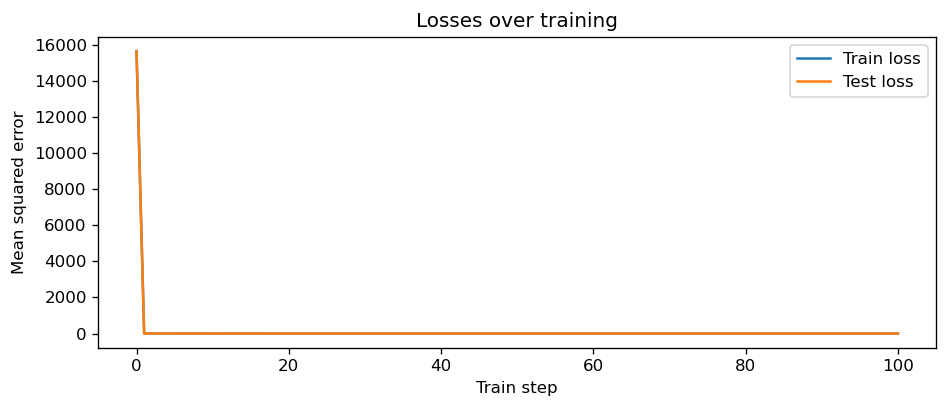

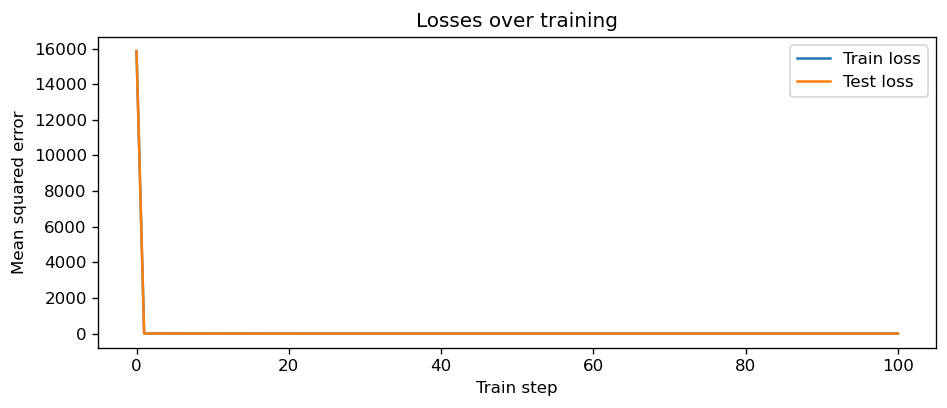

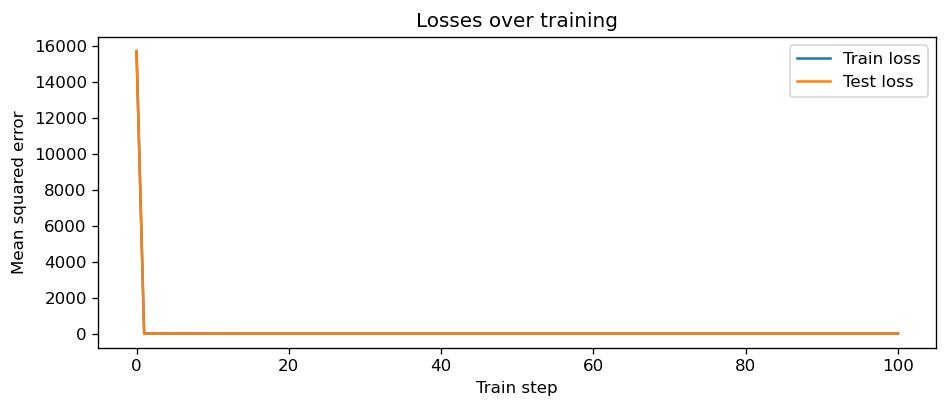

In [ ]:
#experiment_name = 'experiment1'
n = 5
start_idx = 0
init_random_params, nn_forward_fn = stax.serial(
    stax.Dense(128),
    stax.Softplus,
    stax.Dense(128),
    stax.Softplus,
    stax.Dense(1),
)

for i in range(start_idx, start_idx + n):
    name = experiment_name + f'_{i + 1}.pickle'
    
    path = Path(TRAIN_DATASET_PATH, name)

    with open(path, 'rb') as f:
        train_data = pickle.load(f)
        
    with open(path, 'rb') as f:
        test_data = pickle.load(f)

    [x_train, xt_train] = train_data
    [x_test, xt_test] = test_data

    x_train = jax.device_put(jax.vmap(code.train.normalize_dp)(x_train), jax_gpu[0])
    x_test = jax.device_put(jax.vmap(code.train.normalize_dp)(x_test), jax_gpu[0])
    
    print(f"======== {name} ========")
    code.train.train(init_random_params, x_train, xt_train, x_test, xt_test, log_dir=LOG_DIR, name = name)
    
print("======== done! =========")

# Классификация и обработка данных

In [11]:
import code.trajectories_classifing

Загружаем заранее посчитанные лагражианы, представленные в виде коэфициентов для лагражевой нейронной сети

In [10]:
X, y = code.trajectories_classifing.get_data(0, 1299, targets, experiment_name)

Объекты - лагранжианы, представленные в виде коэфициентов для лагражевой нейронной сети.

In [11]:
X.shape

(1299, 17537)

Метки классов для объектов

In [12]:
y.shape

(1299,)

Разделение выборки для обучения

In [13]:
random_state = 124

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state, shuffle = True)

In [14]:
X_train.shape

(1039, 17537)

In [15]:
X_test.shape

(260, 17537)

Применяем метод главных коэффицентов для параметров нейросети, чтобы уменьшить их размерность

In [16]:
X_train_transformed,  X_test_transformed = code.trajectories_classifing.transform_data(X_train, X_test)

Исследуем выборку и посмотрим насколько хорошо разделяются данные по двум главным параметрам для основных активностей

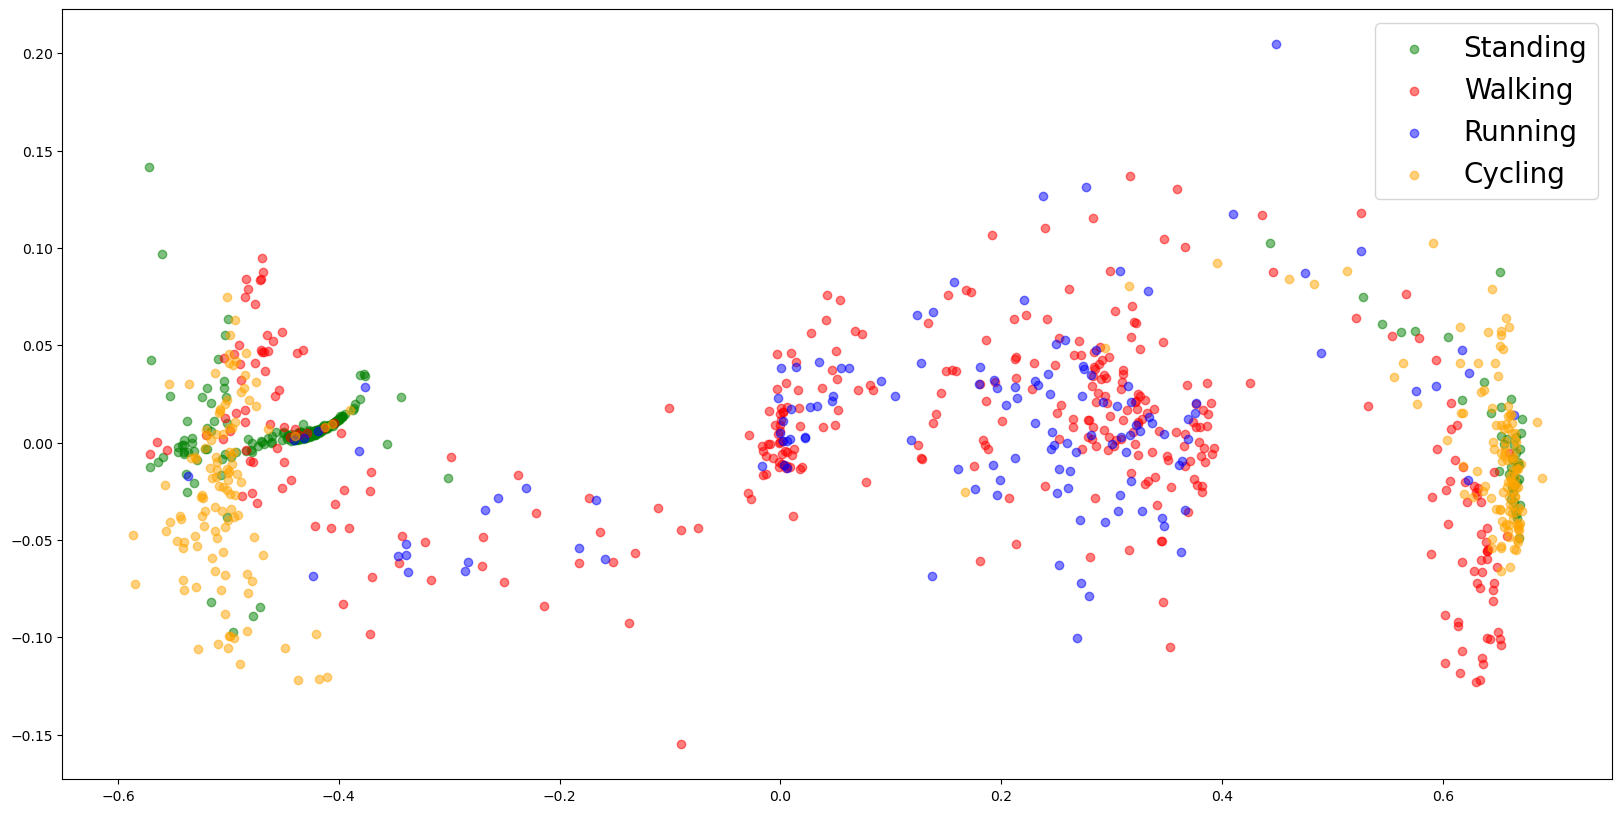

In [17]:
plt.figure(figsize = (20, 10))

X_standing = X_train_transformed[np.where(y_train == 3)]
X_walking = X_train_transformed[np.where(y_train == 4)]
X_running = X_train_transformed[np.where(y_train == 5)]
X_cycling = X_train_transformed[np.where(y_train == 6)]

X_standing_test = X_test_transformed[np.where(y_test == 3)]
X_walking_test = X_test_transformed[np.where(y_test == 4)]
X_running_test = X_test_transformed[np.where(y_test == 5)]
X_cycling_test = X_test_transformed[np.where(y_test == 6)]

plt.scatter(X_standing[:, 1], X_standing[:, 16], alpha = 0.5, color = "green", label = "Standing")
plt.scatter(X_walking[:, 1], X_walking[:, 16], alpha = 0.5, color = 'red', label = "Walking")
plt.scatter(X_running[:, 1], X_running[:, 16], alpha = 0.5, color = 'blue', label = "Running")
plt.scatter(X_cycling[:, 1], X_cycling[:, 16], alpha = 0.5, color = 'orange', label = "Cycling")

#plt.scatter(X_standing_test[:, 0], X_standing_test[:, 5], alpha = 0.5, color = "green")
#plt.scatter(X_walking_test[:, 0], X_walking_test[:, 5], alpha = 0.5, color = 'red')
#plt.scatter(X_running_test[:, 0], X_running_test[:, 5], alpha = 0.5, color = 'blue')
#plt.scatter(X_cycling_test[:, 0], X_cycling_test[:, 5], alpha = 0.5, color = 'orange')

plt.legend(fontsize = 20)
plt.savefig(Path("code/figures", "Data.png"))
plt.show()

Уже по двум параметрам наиболее непохожие активности хорошо разделяются

Исследуем выборку и посмотрим насколько хорошо разделяются данные по трем главным параметрам для основных активностей

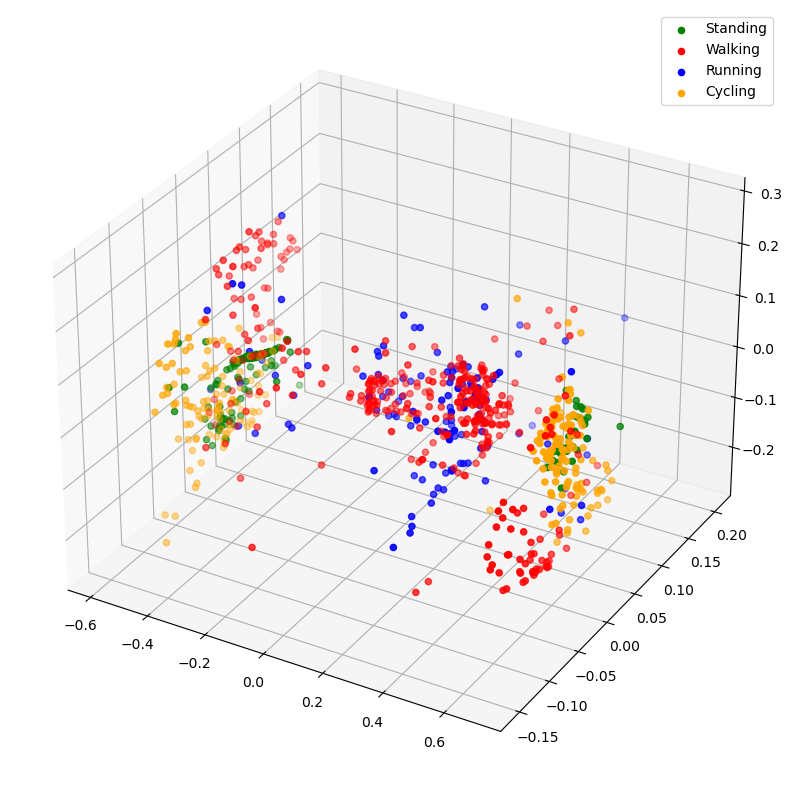

In [18]:
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(111, projection='3d')

X_standing = X_train_transformed[np.where(y_train == 3)]
X_walking = X_train_transformed[np.where(y_train == 4)]
X_running = X_train_transformed[np.where(y_train == 5)]
X_cycling = X_train_transformed[np.where(y_train == 6)]

X_standing_test = X_test_transformed[np.where(y_test == 3)]
X_walking_test = X_test_transformed[np.where(y_test == 4)]
X_running_test = X_test_transformed[np.where(y_test == 5)]
X_cycling_test = X_test_transformed[np.where(y_test == 6)]

ax.scatter(X_standing[:, 1], X_standing[:, 16], X_standing[:, 6], color="green", label = "Standing")
ax.scatter(X_walking[:, 1], X_walking[:, 16], X_walking[:, 6], color="red", label = "Walking")
ax.scatter(X_running[:, 1], X_running[:, 16], X_running[:, 6], color="blue", label = "Running")
ax.scatter(X_cycling[:, 1], X_cycling[:, 16], X_cycling[:, 6], color="orange", label = "Cycling")

#ax.scatter(X_standing_test[:, 0], X_standing_test[:, 1], X_standing_test[:, 5], alpha = 0.5, color = "green")
#ax.scatter(X_walking_test[:, 0], X_walking_test[:, 1], X_walking_test[:, 5], alpha = 0.5, color = 'red')
#ax.scatter(X_running_test[:, 0], X_running_test[:, 1], X_running_test[:, 5], alpha = 0.5, color = 'blue')
#ax.scatter(X_cycling_test[:, 0], X_cycling_test[:, 1], X_cycling_test[:, 5], alpha = 0.5, color = 'orange')

plt.legend(fontsize = 10)
plt.savefig(Path("code/figures", "Data_3D.png"))
plt.show()

По трем главным параметрам большинство активностей разделимы

In [19]:
X_train_transformed,  X_test_transformed = code.trajectories_classifing.transform_data(X_train, X_test, 20)

In [20]:
X_train_transformed.shape

(1039, 20)

In [21]:
X_test_transformed.shape

(260, 20)

Теперь применим несколько алгоритмов классификации, чтобы найти лучший

Логистическая регрессия

In [22]:
regression = LogisticRegression(C=1.0)
regression.fit(X_train_transformed, y_train)

y_pred = regression.predict(X_test_transformed)
acc_score = accuracy_score(y_test, y_pred)

Гауссовский процесс

In [23]:
gpc = GaussianProcessClassifier(kernel=1.0 * RBF(1.0), random_state=random_state)
gpc.fit(X_train_transformed, y_train)

y_pred = gpc.predict(X_test_transformed)
acc_score = accuracy_score(y_test, y_pred)

Случайный лес

In [24]:
forest = RandomForestClassifier(n_estimators=10000)
forest.fit(X_train_transformed, y_train)

y_pred = forest.predict(X_test_transformed)
acc_score = accuracy_score(y_test, y_pred)

К-ближайших соседей

In [25]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train_transformed, y_train)
y_pred = knn.predict(X_test_transformed)
acc_score = accuracy_score(y_test, y_pred)

SVC с гауссовским ядром

In [26]:
from sklearn import svm
#svc = svm.SVC(kernel='linear')
svc = svm.SVC(kernel=RBF(0.34))
svc.fit(X_train_transformed, y_train)
y_pred = svc.predict(X_test_transformed)
acc_score = accuracy_score(y_pred, y_test)

In [27]:
y_pred.shape

(260,)

In [28]:
print(acc_score)

0.823076923076923


Исследуем как ведут себя эти методы для разного количества главных компонент

In [34]:
x, y_1, y_2, y_3, y_4, y_train_1, y_train_2, y_train_3, y_train_4 =  code.trajectories_classifing.compareClassifiresperPCA(2, 30, X_train, X_test, y_train, y_test , random_state)

100%|██████████| 28/28 [06:26<00:00, 13.79s/it]


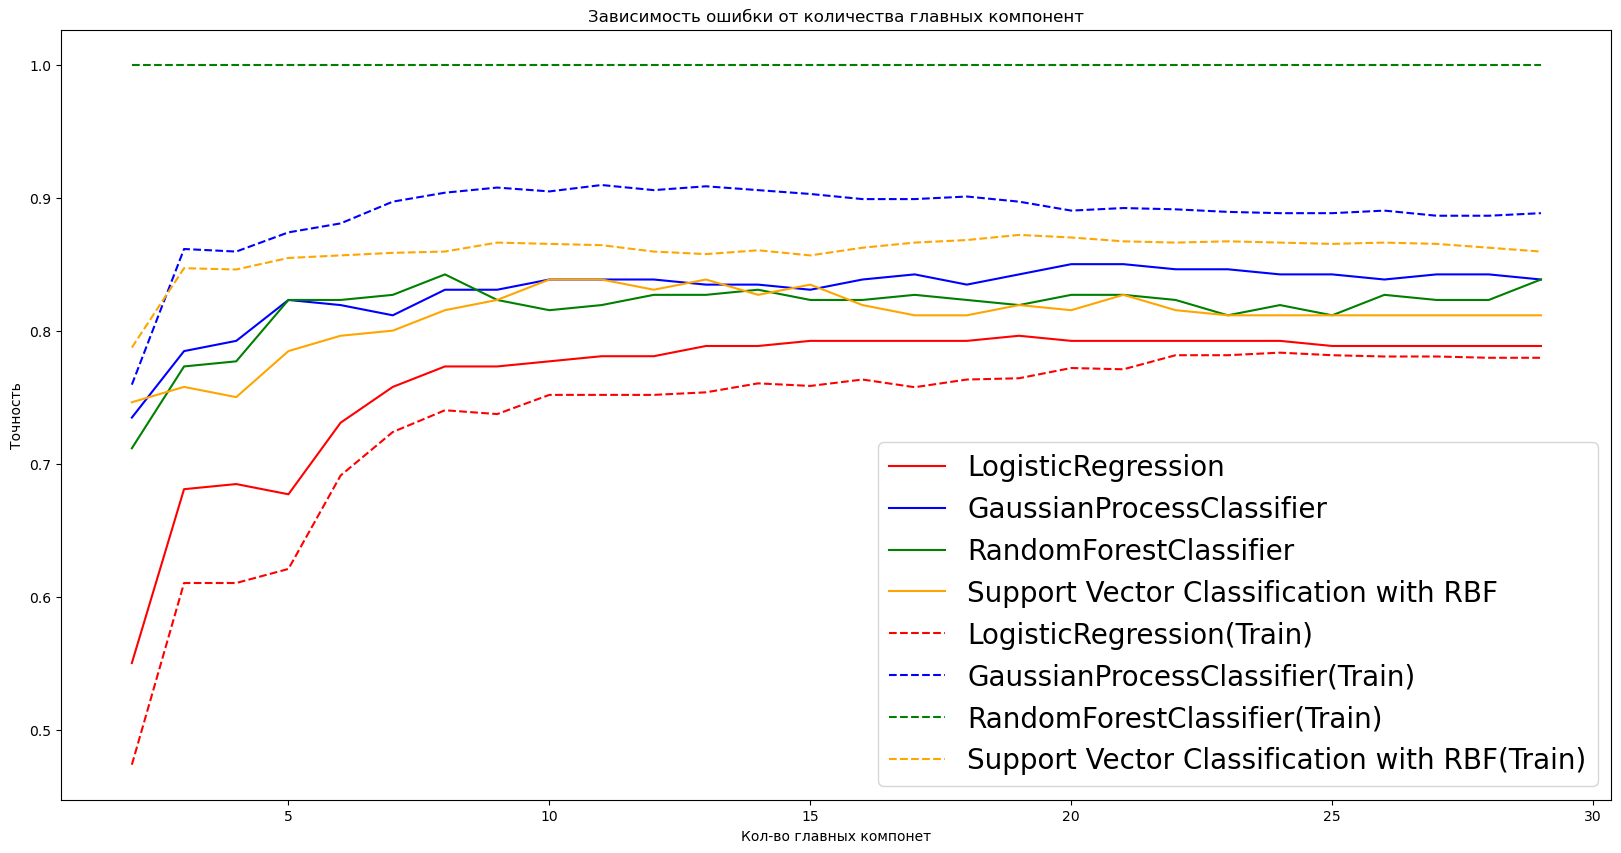

In [35]:
plt.figure(figsize = (20, 10))
plt.plot(x, y_1, color="red", label = "LogisticRegression")
plt.plot(x, y_2, color="blue", label = "GaussianProcessClassifier")
plt.plot(x, y_3, color="green", label = "RandomForestClassifier")
plt.plot(x, y_4, color="orange", label = "Support Vector Classification with RBF")
plt.plot(x, y_train_1, color="red", linestyle = '--',   label = "LogisticRegression(Train)")
plt.plot(x, y_train_2, color="blue", linestyle = '--', label = "GaussianProcessClassifier(Train)")
plt.plot(x, y_train_3, color="green", linestyle = '--', label = "RandomForestClassifier(Train)")
plt.plot(x, y_train_4, color="orange", linestyle = '--', label = "Support Vector Classification with RBF(Train)")
plt.xlabel("Кол-во главных компонет")
plt.ylabel("Точность")
plt.title("Зависимость ошибки от количества главных компонент")
plt.legend(fontsize = 20)
plt.savefig(Path("code/figures", "Accuracy.png"))
plt.show()

Видно, что классификация с использованием гауссовского ядра и случайного леса показали наилучший результат. Следовательно для данной природы данных гауссовское ядро подходит лучше всего. Что и ожидаемо, т.к. на графикуе для трех компонет аидно, что классы расположены в определенных сгустках